In [1]:
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import  DataLoader
import torchvision.utils as vutils
import torch.optim as optim
import torch.autograd as autograd
from AADB.AADB import AADB_binaries, AADB_classes
from TheSUN.SUN import SUN
from models.ACGAN import Generator, Discriminator
from utils.utils import *
from models.ResNet18 import RegressionNetwork

### Variables

In [2]:
batch_size = 64
max_epochs = 600
latent_dim = 128
n_channels = 3
image_size = 128
ngf = 128   # feature map gen
ndf = 128   # feature map disc
beta = 0.5  # Adam
lr = 0.00005  # Learning rate for optimizers
is_load = False
ckpt_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\cGAN_128x128\checkpoint_iteration_186599.tar'  # to set if checkpoint

In [3]:
n_critic = 15
lam_gp = 10

### AADB

In [4]:
image_dir = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\ImageAesthetics_ECCV2016\datasetImages_warp256'
label_csv_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'
samples_path = "F:\Projects\Disertatie\ImageAestheticsGANs\cGAN_128x128"
os.makedirs(samples_path, exist_ok=True)

In [5]:
aadb = AADB_binaries(image_dir, label_csv_path)
aadb_test = AADB_binaries(image_dir, label_csv_path, test=True)
n_classes = AADB_binaries.get_classes()

In [6]:
sun = SUN()

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])


8958

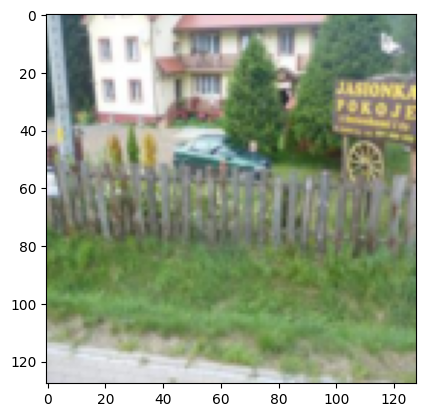

In [7]:
show_example(*aadb[0])
len(aadb)

tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0])


1000

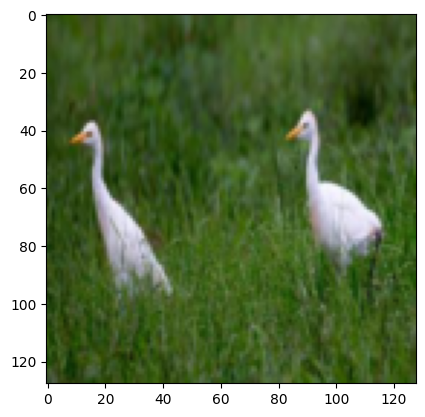

In [8]:
show_example(*aadb_test[0])
len(aadb_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=torch.int32)


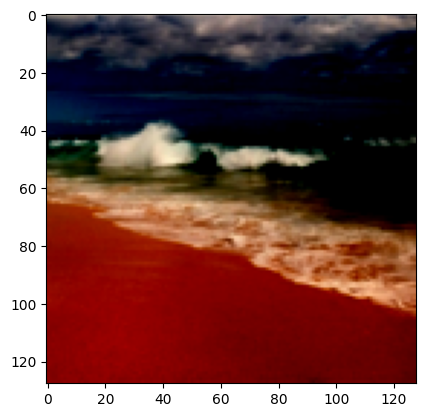

In [9]:
show_example(*sun[2056])

In [10]:
aadb = aadb + aadb_test + sun

In [11]:
len(aadb)

26831

### Dataloaders

In [12]:
train_dl = DataLoader(aadb, batch_size*2, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


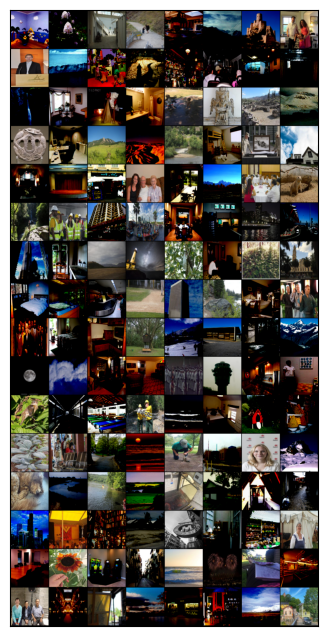

In [13]:
show_batch(train_dl)

In [14]:
for image, labels in train_dl:
    print(image.shape)
    print(type(labels))
    print(labels.shape)
    break

torch.Size([128, 3, 128, 128])
<class 'torch.Tensor'>
torch.Size([128, 12])


In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Sample Noise

In [16]:
n_sample = 64

sample_noise = torch.randn(n_sample, latent_dim, device=device)
sample_labels = torch.zeros(n_sample, n_classes, dtype=torch.float32, device=device)

for i in range(n_sample):
    label_init = torch.randint(2, (n_classes,), dtype=torch.float32, device=device)
    for j in range(len(label_init)):
        sample_labels[i][j] = label_init[j]
        if j == n_classes-1:
            sample_labels[i][j] = 1

### Models and Loss

In [17]:
net_G = Generator(ngf, n_classes, image_size, n_channels, latent_dim).to(device)
net_D = Discriminator(ndf, n_channels, image_size, n_classes).to(device)

In [18]:
print(net_G)
print(net_D)

Generator(
  (exp): Linear(in_features=12, out_features=28, bias=True)
  (main): Sequential(
    (0): Linear(in_features=156, out_features=65536, bias=True)
    (1): Reshape()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [19]:
def MBCE(input, target, esp=1e-19):
    loss = - torch.mean(target * torch.log(input.clamp_min(esp))) - torch.mean(
        (1 - target) * torch.log((1 - input).clamp_min(esp)))
    return loss

In [20]:
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta, 0.999))

In [21]:
def gradient_penalty(x, y, f):
    # interpolation
    shape = [x.size(0)] + [1] * (x.dim() - 1)
    alpha = torch.rand(shape, device=device)
    z = x + alpha * (y - x)

    z.requires_grad = True
    o = f(z)[0]
    ones = torch.ones(o.size(), device=device)
    g = autograd.grad(o, z, grad_outputs=ones, create_graph=True)[0].view(z.size(0), -1)
    gp = ((g.norm(p=2, dim=1) - 1) ** 2).mean()

    return gp

In [22]:
def save_diagram_loss(list_1, list_2,
                 label1="D", label2="G",
                 title="Generator and Discriminator loss During Training",
                 x_label="iterations", y_label="Loss",
                 path=samples_path,
                 name='loss.jpg'
                 ):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(list_1, label=label1)
    plt.plot(list_2, label=label2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(os.path.join(path, name))
    plt.close()

In [ ]:
if is_load:
    print("Loading checkpoint...")

    checkpoint = torch.load(ckpt_path)
    last_epoch = checkpoint['epoch']
    iteration = checkpoint['iteration']
    last_i = checkpoint['last_current_iteration']
    sample_noise = checkpoint['sample_noise']

    list_loss_D = checkpoint['list_loss_D']
    list_loss_G = checkpoint['list_loss_G']

    loss_D = list_loss_D[-1]
    loss_G = list_loss_G[-1]

    net_D.load_state_dict(checkpoint['netD_state_dict'])
    net_G.load_state_dict(checkpoint['netG_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    net_D.eval()
    net_G.eval()

else:
    last_epoch = 0
    iteration = 0

    list_loss_G = []
    list_loss_D = []

print("Starting Training Loop...")
for epoch in range(last_epoch, max_epochs):
    str_i = 0
    if is_load:
        str_i = last_i
    for i, (real_img, real_c) in enumerate(train_dl, str_i):

        # -----------------------------------------------------------
        # Initial batch
        real_img, real_c = real_img.to(device), real_c.to(device)
        real_batch_size = real_img.size(0)
        noise = torch.randn(real_batch_size, latent_dim, device=device)
        # random label
        fake_c = torch.randint(5, (real_batch_size, n_classes), dtype=torch.float32, device=device)
        fake_img = net_G(noise, fake_c)

        # -----------------------------------------------------------
        # Update D network: minimize: -(D(x) - D(G(z)))+ lambda_gp * gp + class_loss (gradient penalty)
        net_D.zero_grad()

        v, c = net_D(real_img)
        loss_real = (- torch.mean(v) + MBCE(c, real_c)) * 0.5
        v, c = net_D(fake_img.detach())
        loss_fake = (torch.mean(v) + MBCE(c, fake_c)) * 0.5
        gp = gradient_penalty(real_img.detach(), fake_img.detach(), net_D)
        loss_D = (loss_real + loss_fake) * 0.5 + lam_gp * gp  # total loss of D

        # Update D
        loss_D.backward()
        optimizer_D.step()

        # -----------------------------------------------------------
        # Update G network: maximize D(G(z)) , equal to minimize - D(G(z))
        if i % n_critic == 0:
            net_G.zero_grad()

            # Calculate G loss
            v, c = net_D(fake_img)

            loss_G = (- torch.mean(v) + MBCE(c, fake_c)) * 0.5

            # Update G
            loss_G.backward()
            optimizer_G.step()

        # -----------------------------------------------------------
        # Output training stats
        with torch.no_grad():
            list_loss_D.append(loss_D.item())

            if type(loss_G) == float:
                list_loss_G.append(loss_G)
            else:
                list_loss_G.append(loss_G.item())

            if i % 100 == 0: # batches
                print(
                    '[%d/%d][%2d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch, max_epochs, i, len(train_dl),
                       list_loss_D[-1], list_loss_G[-1]))

            # Output sample noise
            if (iteration % 500 == 0) or ((epoch == max_epochs - 1) and (i == len(train_dl) - 1)):
                samples = net_G(sample_noise, sample_labels).cpu()
                vutils.save_image(samples, os.path.join(samples_path, '%d.jpg' % iteration), padding=2, normalize=True)
                save_diagram_loss(list_loss_D, list_loss_G, name='loss.jpg')

            # Save model after 5000 iterations
            if (iteration % 5000 == 0) or ((epoch == max_epochs - 1) and (i == len(train_dl) - 1)):
                save_path = os.path.join(samples_path, 'checkpoint_iteration_%d.tar' % iteration)
                torch.save({
                    'epoch': epoch,
                    'iteration': iteration,
                    'last_current_iteration': i,
                    'netD_state_dict': net_D.state_dict(),
                    'netG_state_dict': net_G.state_dict(),
                    'optimizer_D_state_dict': optimizer_D.state_dict(),
                    'optimizer_G_state_dict': optimizer_G.state_dict(),
                    'list_loss_D': list_loss_D,
                    'list_loss_G': list_loss_G,
                    'sample_noise': sample_noise
                }, save_path)

        # iteration: total iteration, i: iteration of current epoch
        iteration += 1
        is_load = False

Starting Training Loop...
[0/600][ 0/209]	Loss_D: 0.8808	Loss_G: 1.2885
[0/600][100/209]	Loss_D: -55.8634	Loss_G: 46.5481
[0/600][200/209]	Loss_D: -46.6845	Loss_G: 45.4483
[1/600][ 0/209]	Loss_D: -46.8753	Loss_G: 35.1430
[1/600][100/209]	Loss_D: -47.1807	Loss_G: 65.7645
[1/600][200/209]	Loss_D: -46.1074	Loss_G: 49.4540
[2/600][ 0/209]	Loss_D: -45.3841	Loss_G: 50.2559
[2/600][100/209]	Loss_D: -35.2515	Loss_G: 38.2056
[2/600][200/209]	Loss_D: -29.5579	Loss_G: 11.4473
[3/600][ 0/209]	Loss_D: -29.6642	Loss_G: 5.3032
[3/600][100/209]	Loss_D: -27.5531	Loss_G: -0.6353
[3/600][200/209]	Loss_D: -28.7778	Loss_G: -10.4168
[4/600][ 0/209]	Loss_D: -25.7006	Loss_G: -11.0737
[4/600][100/209]	Loss_D: -27.2699	Loss_G: -1.7680
[4/600][200/209]	Loss_D: -26.5656	Loss_G: 1.3061
[5/600][ 0/209]	Loss_D: -23.2278	Loss_G: -17.6234
[5/600][100/209]	Loss_D: -23.1320	Loss_G: 0.1675
[5/600][200/209]	Loss_D: -22.7212	Loss_G: -3.2213
[6/600][ 0/209]	Loss_D: -24.7968	Loss_G: -8.1252
[6/600][100/209]	Loss_D: -24.3897	

# Testing

In [12]:
testing_model = RegressionNetwork(backbone='resnet18', num_attributes=11, pretrained=True)
testing_model = testing_model.to('cuda')
testing_model.load_state_dict(torch.load("F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt\AADB_epoch_99_loss_0.0743_.pt"))
testing_model.eval()

RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [10]:
checkpoint = torch.load(ckpt_path)
gen = Generator(ngf, n_classes, image_size, n_channels, latent_dim).to('cuda')
gen.load_state_dict(checkpoint['netG_state_dict'])
gen.eval()

Generator(
  (exp): Linear(in_features=11, out_features=28, bias=True)
  (main): Sequential(
    (0): Linear(in_features=284, out_features=65536, bias=True)
    (1): Reshape()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [33]:
sample_noise = torch.randn(1, latent_dim, device=device)
# test_labels = torch.randint(5, (n_classes,), dtype=torch.float32, device=device).view(1,n_classes)
test_labels = torch.tensor([2, 1, 0, 4, 3, 2, 2, 0, 2, 1, 1], dtype=torch.float32, device=device)

In [34]:
sample = gen(sample_noise, test_labels.view(1,n_classes)).squeeze().cpu().detach()

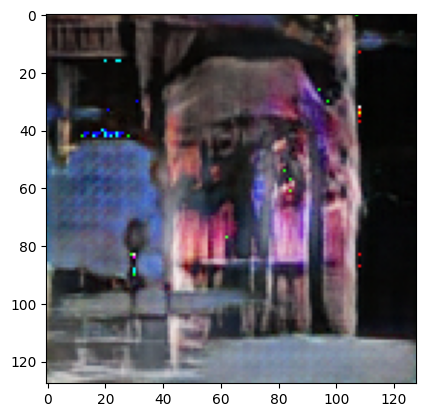

In [35]:
plt.imshow(to_pil(sample))

In [28]:
sample_tensor = sample.to("cuda").unsqueeze(0)
y_pred = testing_model(sample_tensor)
y_pred = np.clip(y_pred.cpu().detach().numpy(), 0, 1.0)
y_pred = round_labels(y_pred)
y = test_labels.cpu().numpy()

NameError: name 'testing_model' is not defined

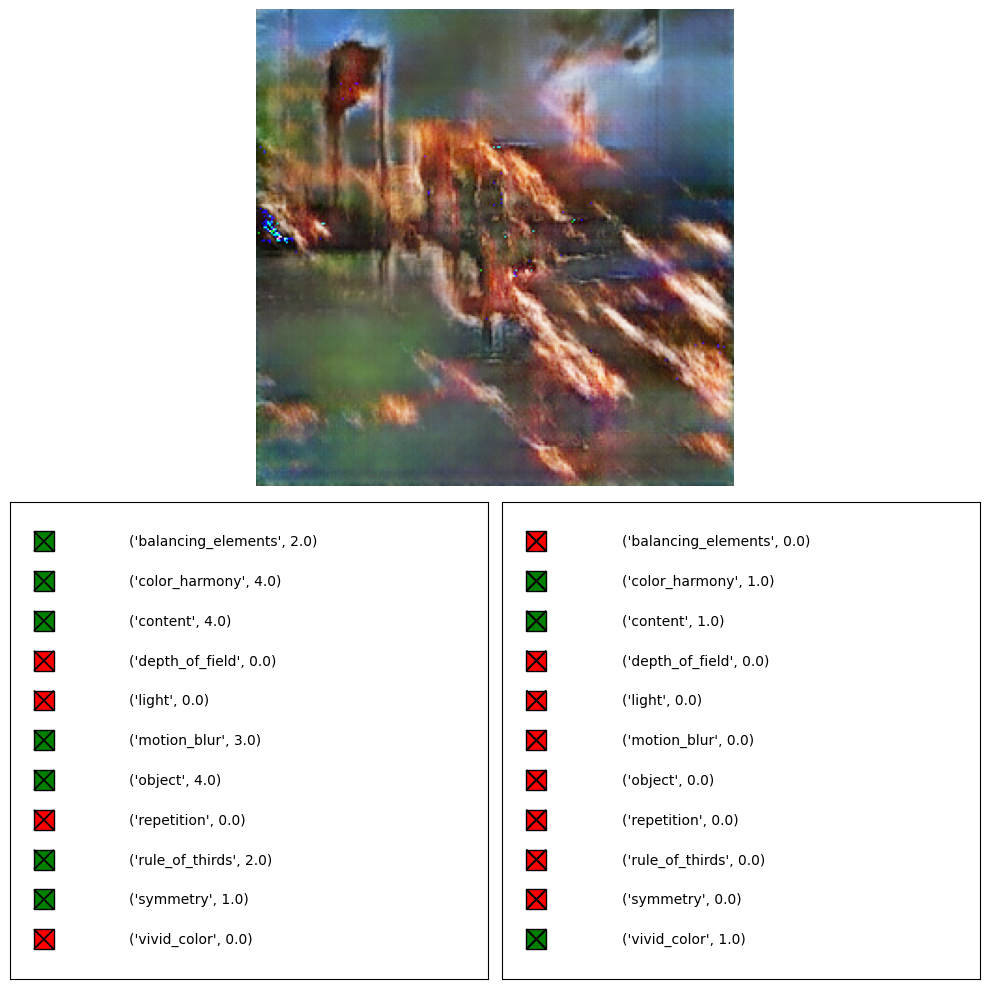

In [75]:
display_aesthetics(sample, y, y_pred, interval=[0.199, 0.2], score=False)